市场行为中存在一种对立现象：在短期基础上，价格倾向于均值回归 (mean revert)，而在中期则能观察到动量效应 (momentum manner)。这对任何趋势跟踪策略都具有本质性的背景影响，因为趋势跟踪信号常常在超买或超卖条件下触发。

In [92]:
import pandas as pd
import os
# 数据文件路径
data_dir = '../data'
csv_filename = 'detect/data_US_SOXX_K_DAY.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
display(df.tail(10))

,open,close,volume,high,low
Date,,,,,
2025-06-18 00:00:00-04:00,226.850006,226.559998,6657600,229.190002,225.100006
2025-06-20 00:00:00-04:00,228.789993,225.110001,8202300,229.080002,222.160004
2025-06-23 00:00:00-04:00,225.020004,226.509995,7115100,227.889999,221.860001
2025-06-24 00:00:00-04:00,230.570007,235.100006,7017500,235.360001,230.460007
2025-06-25 00:00:00-04:00,236.660004,237.210007,5252500,237.240005,234.800003
2025-06-26 00:00:00-04:00,239.039993,239.070007,4350100,239.649994,237.179993
2025-06-27 00:00:00-04:00,239.309998,238.860001,4520500,241.229996,236.369995
2025-06-30 00:00:00-04:00,240.169998,238.699997,4925300,240.169998,237.559998
2025-07-01 00:00:00-04:00,236.699997,237.619995,10892900,239.179993,234.080002


### 计算40个趋势指标信号​​
​​指标类型​​（论文图1）：
变化率（RoC）：24/32/48/64/96/128/192/256/384/512日

简单移动平均（SMA）：24/32/48/64/96/128/192/256/384/512日

均线交叉（Crossover）：(20,400)、(50,400)、(100,400)、(200,400)、(20,200)、(50,200)、(100,200)、(20,100)、(50,100)、(20,50)

线性回归斜率（LinearReg）：3/4/5/6/7/8/9/12/15/18日
​
​信号规则​​：
买入信号 → 1.0
卖出信号 → -1.0
模糊/无信号 → 0.0（如斜率绝对值＜统计误差）

TrendScore = (1/40) * Σ(TrendIndicator_i)  # i=1 to 40

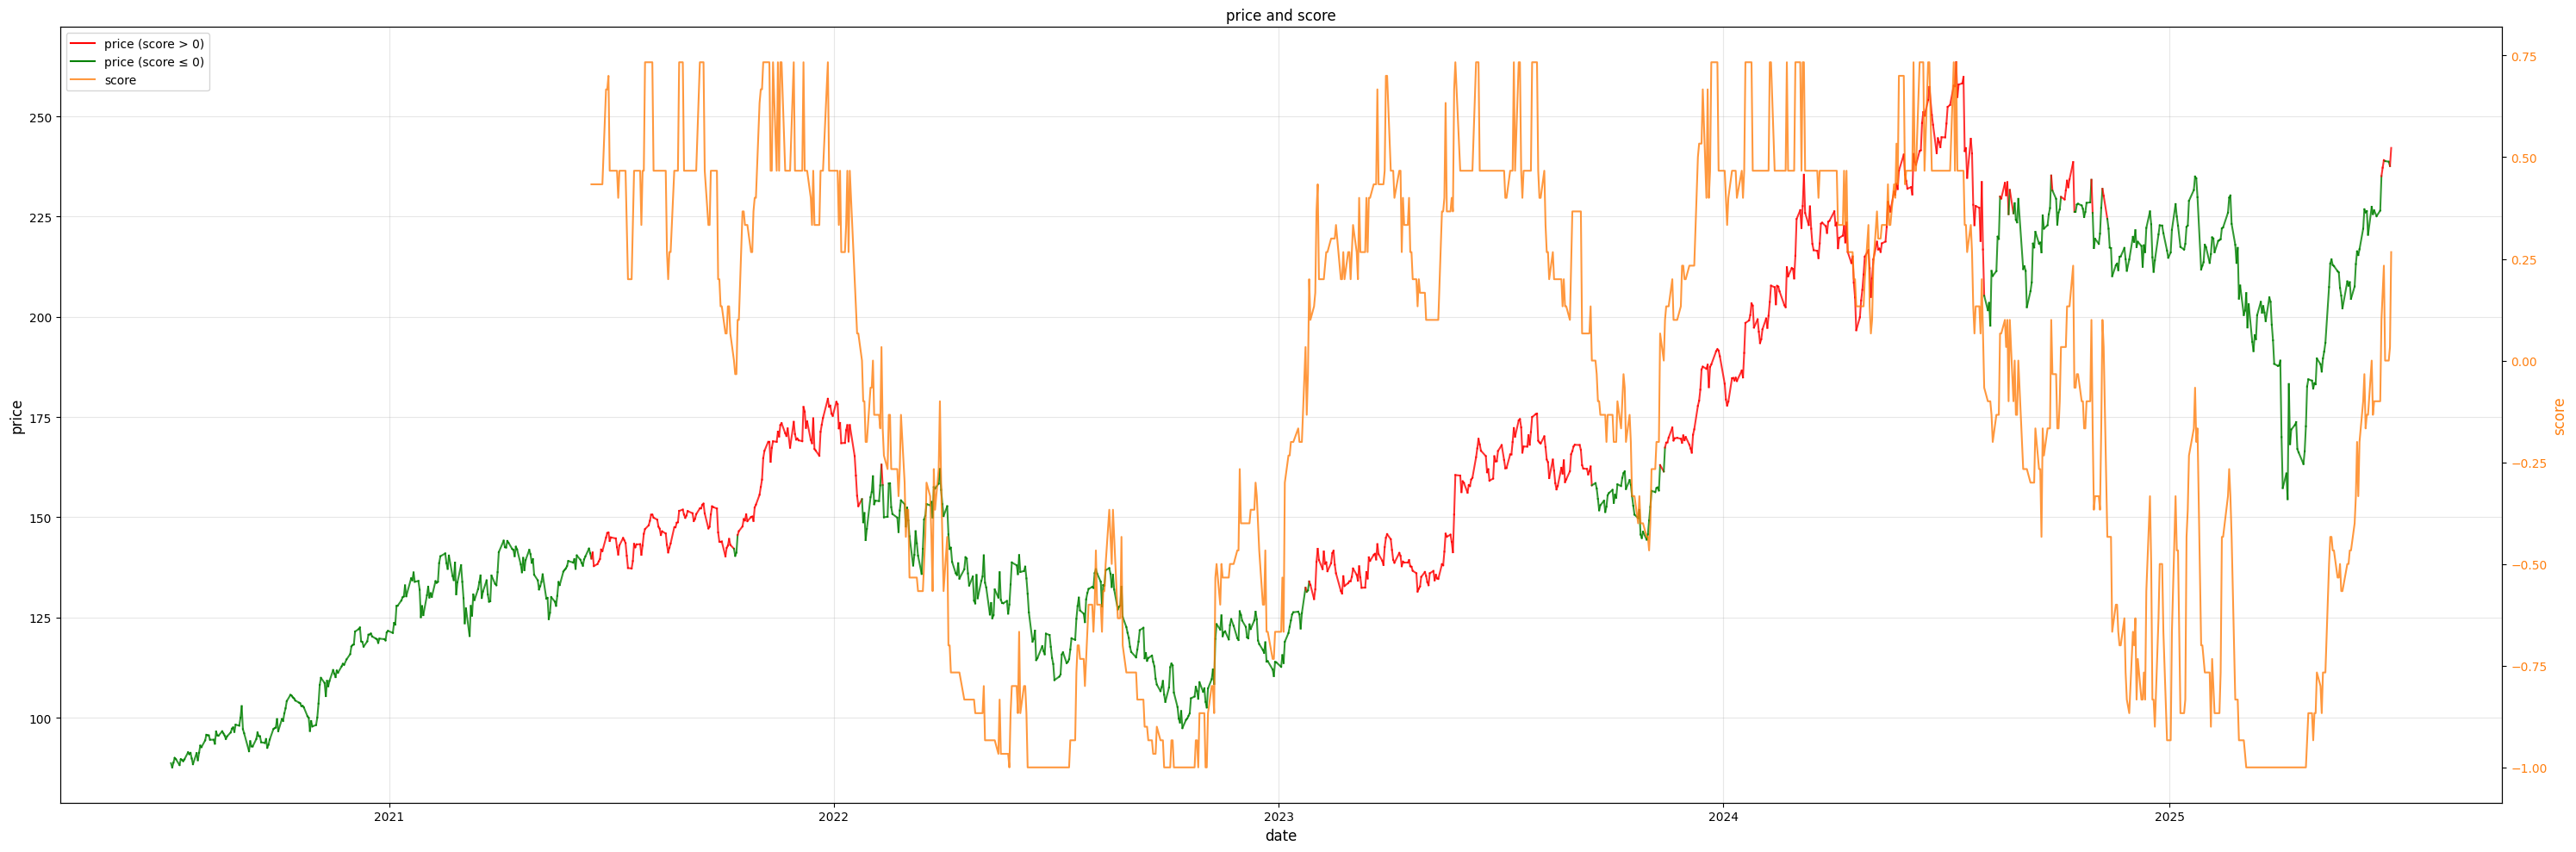

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rate_of_change(price:pd.Series,N:int):
    # is the price higher than n days ago
    high = price.rolling(window=N).max()
    return np.select([price > high, price < high], [1, -1], default=0)

def simple_moving_average(price:pd.Series,N:int):
    # is the price above or below the SMA
    sma = price.rolling(window=N).mean()
    return np.select([price > sma, price < sma], [1, -1], default=0)

def cross_system(price:pd.Series,N:int,M:int):
    # is shorter SMA above or below the longer SMA
    assert N < M, "N must be less than M"
    sma_N = price.rolling(window=N).mean()
    sma_M = price.rolling(window=M).mean()
    return np.select([sma_N > sma_M, sma_N < sma_M], [1, -1], default=0)

def linear_regression(price:pd.Series,N:int):
    # slope of the regression greater, less or close to 0?
    def linear_regression_slope(y:np.ndarray):
        x = np.arange(len(y))
        cov = np.cov(x, y)
        beta1 = cov[0,1] / cov[0,0]
        residuals = y - (beta1*x + np.mean(y) - beta1*np.mean(x))
        se = np.sqrt(np.sum(residuals**2)/(len(y)-2)) / np.sqrt(np.sum((x-np.mean(x))**2))
        return np.select([beta1 > se, beta1 < -se, np.abs(beta1) < se], [1, -1, 0])
    return price.rolling(window=N).apply(linear_regression_slope)

def trend_score(price:pd.Series):
    roc = [24,32,48,64,96,128,192,256,384,512]
    sma = [24,32,48,64,96,128,192,256,384,512]
    cross = [(20,400),(50,400),(100,400),(200,400),(20,200),(50,200),(100,200),(20,100),(50,100),(20,50)]
    lr = [60,80,100,120,140,160,180,240,300,360] # 3/4/5/6/7/8/9/12/15/18 months
    # roc = [24,32,48,64,96,128,192,256]
    # sma = [24,32,48,64,96,128,192,256]
    # cross = [(20,200),(50,200),(100,200),(20,100),(50,100),(20,50)]
    # lr = [60,80,100,120,140,160,180,240] # 3/4/5/6/7/8/9/12 months
    score = pd.Series(0,index=price.index)
    for i in range(len(roc)):
        score += rate_of_change(price,roc[i])
    for i in range(len(sma)):
        score += simple_moving_average(price,sma[i])
    for i in range(len(cross)):
        score += cross_system(price,cross[i][0],cross[i][1])
    for i in range(len(lr)):
        score += linear_regression(price,lr[i])
    return score / (len(roc) + len(sma) + len(cross) + len(lr))

def score_plot(price:pd.Series,score:pd.Series):
    # 创建图形和主坐标轴
    fig, ax1 = plt.subplots(figsize=(30, 10))
    
    # 根据score值确定颜色
    colors = ['red' if s > 0 else 'green' for s in score]
    
    # 绘制价格数据（左y轴），根据score值染色
    ax1.set_xlabel('date', fontsize=12)
    ax1.set_ylabel('price', fontsize=12)
    
    # 分段绘制价格线，每段使用不同颜色
    for i in range(len(price.index) - 1):
        ax1.plot(price.index[i:i+2], price.iloc[i:i+2], 
                color=colors[i], linewidth=1.5, alpha=0.8)
    
    # 添加价格标签到图例
    from matplotlib.lines import Line2D
    red_line = Line2D([0], [0], color='red', linewidth=1.5, label='price (score > 0)')
    green_line = Line2D([0], [0], color='green', linewidth=1.5, label='price (score ≤ 0)')
    
    ax1.tick_params(axis='y')
    
    # 创建右y轴并绘制分数数据
    ax2 = ax1.twinx()
    color2 = '#ff7f0e'  # 橙色
    ax2.set_ylabel('score', color=color2, fontsize=12)
    line2 = ax2.plot(score.index, score, color=color2, linewidth=1.5, label='score',alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # 设置网格
    ax1.grid(True, alpha=0.3)
    
    # 添加图例
    ax1.legend([red_line, green_line, line2[0]], 
              ['price (score > 0)', 'price (score ≤ 0)', 'score'], 
              loc='upper left')
    
    # 设置标题
    plt.title('price and score')
    
    # 调整布局
    plt.tight_layout()
    plt.show()

df_trend = df.copy()
price = df_trend['close']
score_trend = trend_score(price)
score_plot(price,score_trend)






### 基准比较
Ratio = Stock_Close / Benchmark_Close

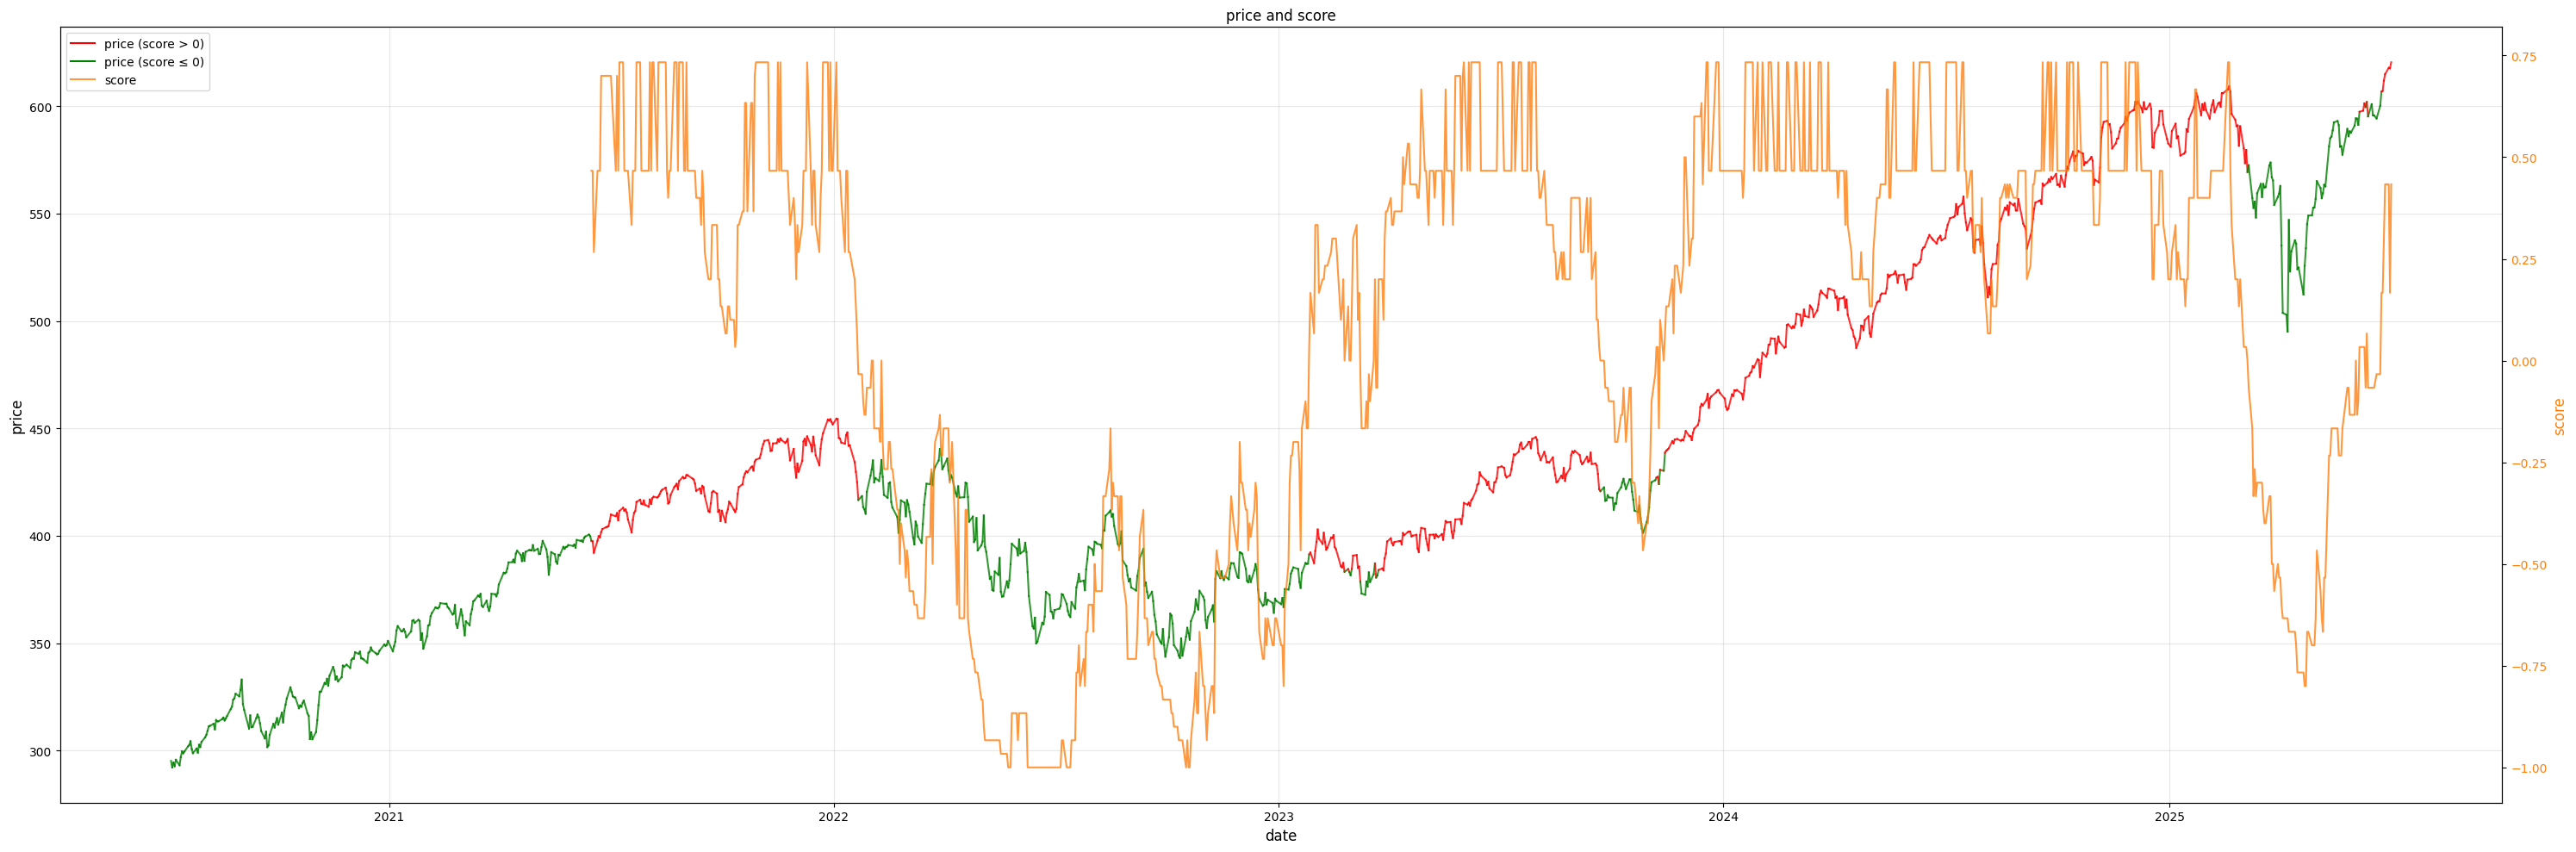

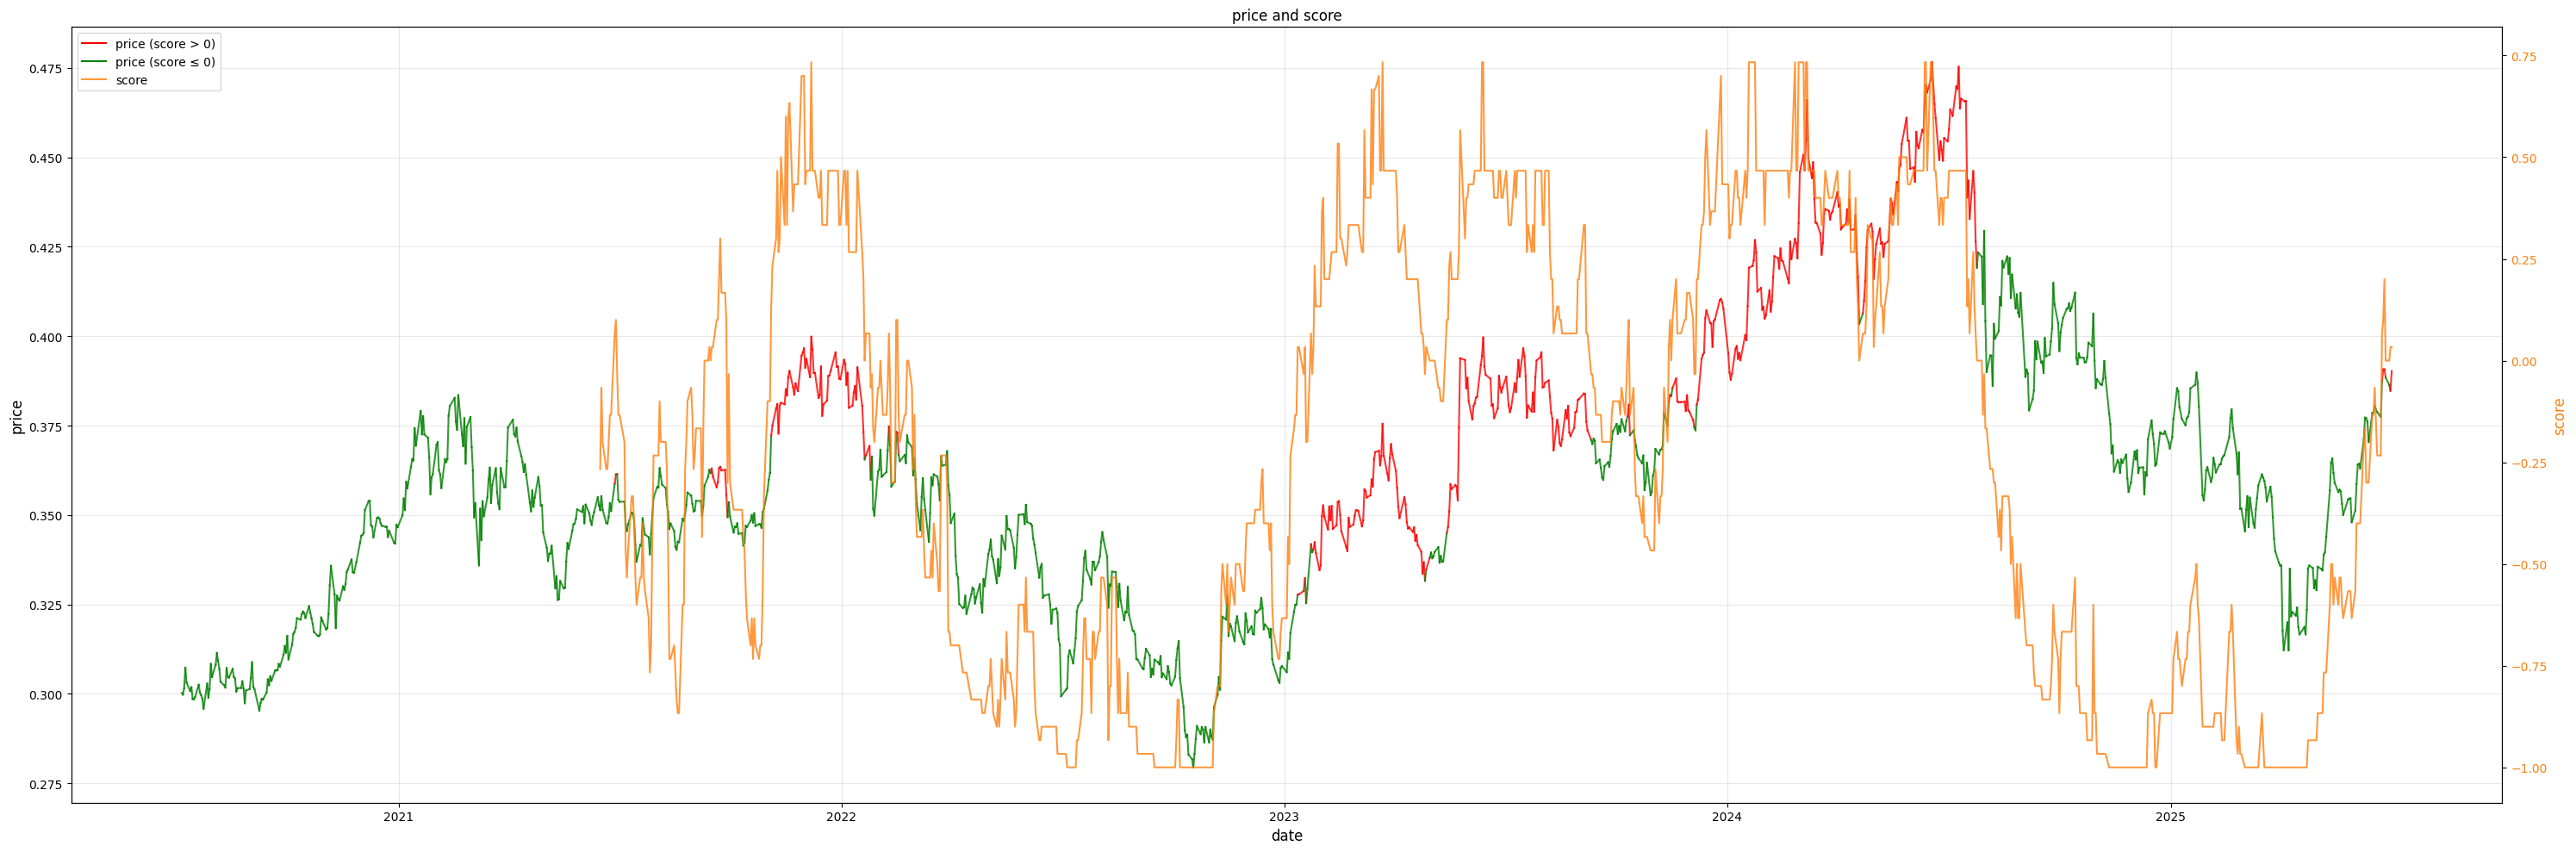

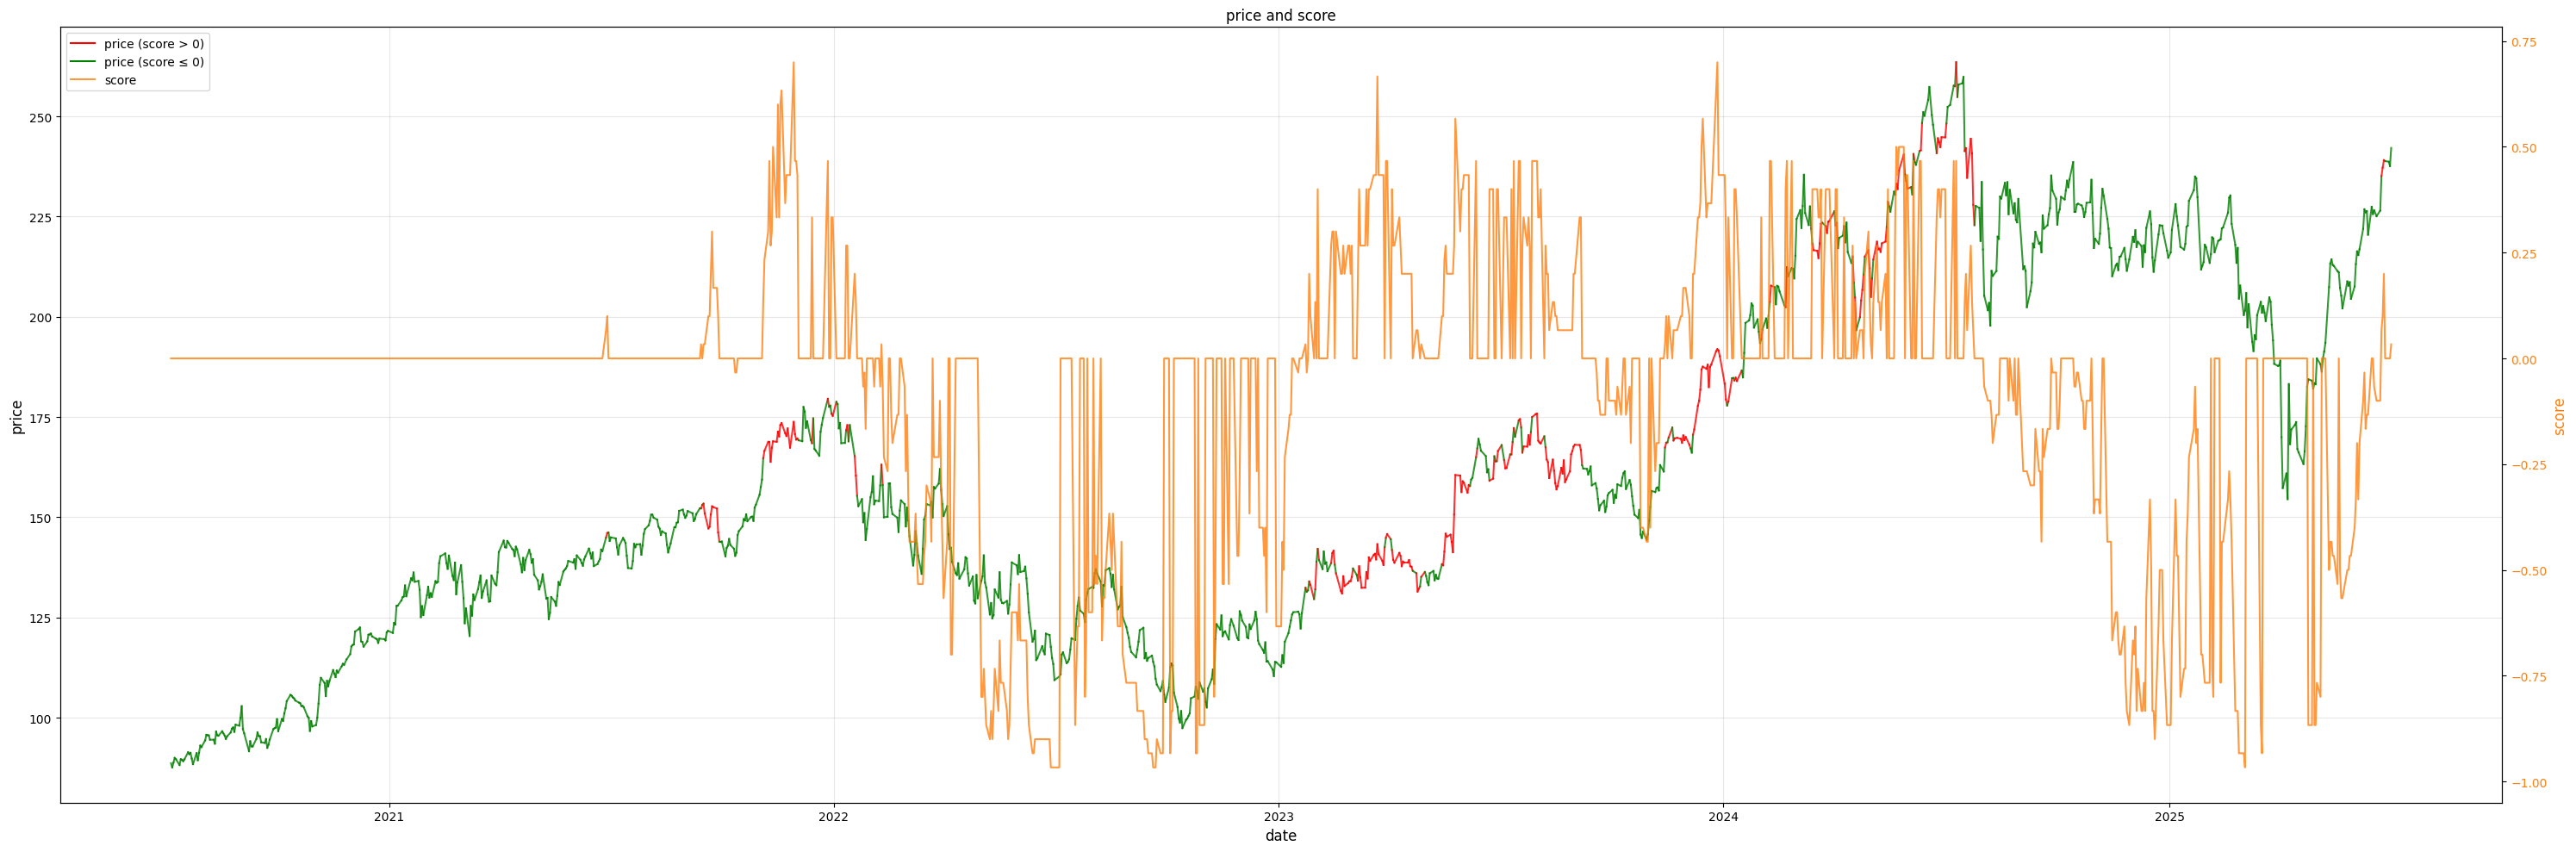

In [94]:
import pandas as pd
import os
# 数据文件路径
data_dir = '../data'
csv_filename = 'detect/data_US_SPY_K_DAY.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df_benchmark = pd.read_csv(csv_path, index_col=0, parse_dates=True)
score_benchmark = trend_score(df_benchmark['close'])
score_plot(df_benchmark['close'],score_benchmark)

df_stock = df.copy()

score_ratio = trend_score(df_stock['close'] / df_benchmark['close'])
score_plot(df_stock['close'] / df_benchmark['close'],score_ratio)

def joint_score(stock_price:pd.Series,benchmark_price:pd.Series):
    price_ratio = stock_price / benchmark_price

    trend_score_benchmark  = trend_score(price_ratio)
    trend_score_stock = trend_score(stock_price)
    up_condition = (trend_score_benchmark > 0) & (trend_score_stock > 0)
    down_condition = (trend_score_benchmark < 0) & (trend_score_stock < 0)

    score = np.select(
        [
        up_condition & (trend_score_stock > trend_score_benchmark),
        up_condition & (trend_score_stock < trend_score_benchmark),
        down_condition & (trend_score_stock > trend_score_benchmark),
        down_condition & (trend_score_stock < trend_score_benchmark)
        ],
        [trend_score_benchmark,trend_score_stock,trend_score_stock,trend_score_benchmark],
        default=0
    )
    return pd.Series(index=stock_price.index,data=score)

score_joint = joint_score(df_stock['close'],df_benchmark['close'])
score_plot(df_stock['close'],score_joint)




### 计算12个振荡器​​（论文图2）
​
​类型​​：
RSI（相对强弱指数）：5/10/14/20日

K线波动范围（Candle Range）：3/5/8/13日
​
​标准化​​：将输出缩放到[-1.0, 1.0]

-1.0：严重超卖
1.0：严重超买

EmotionIndex = (1/12) * Σ(Oscillator_i)  # i=1 to 12

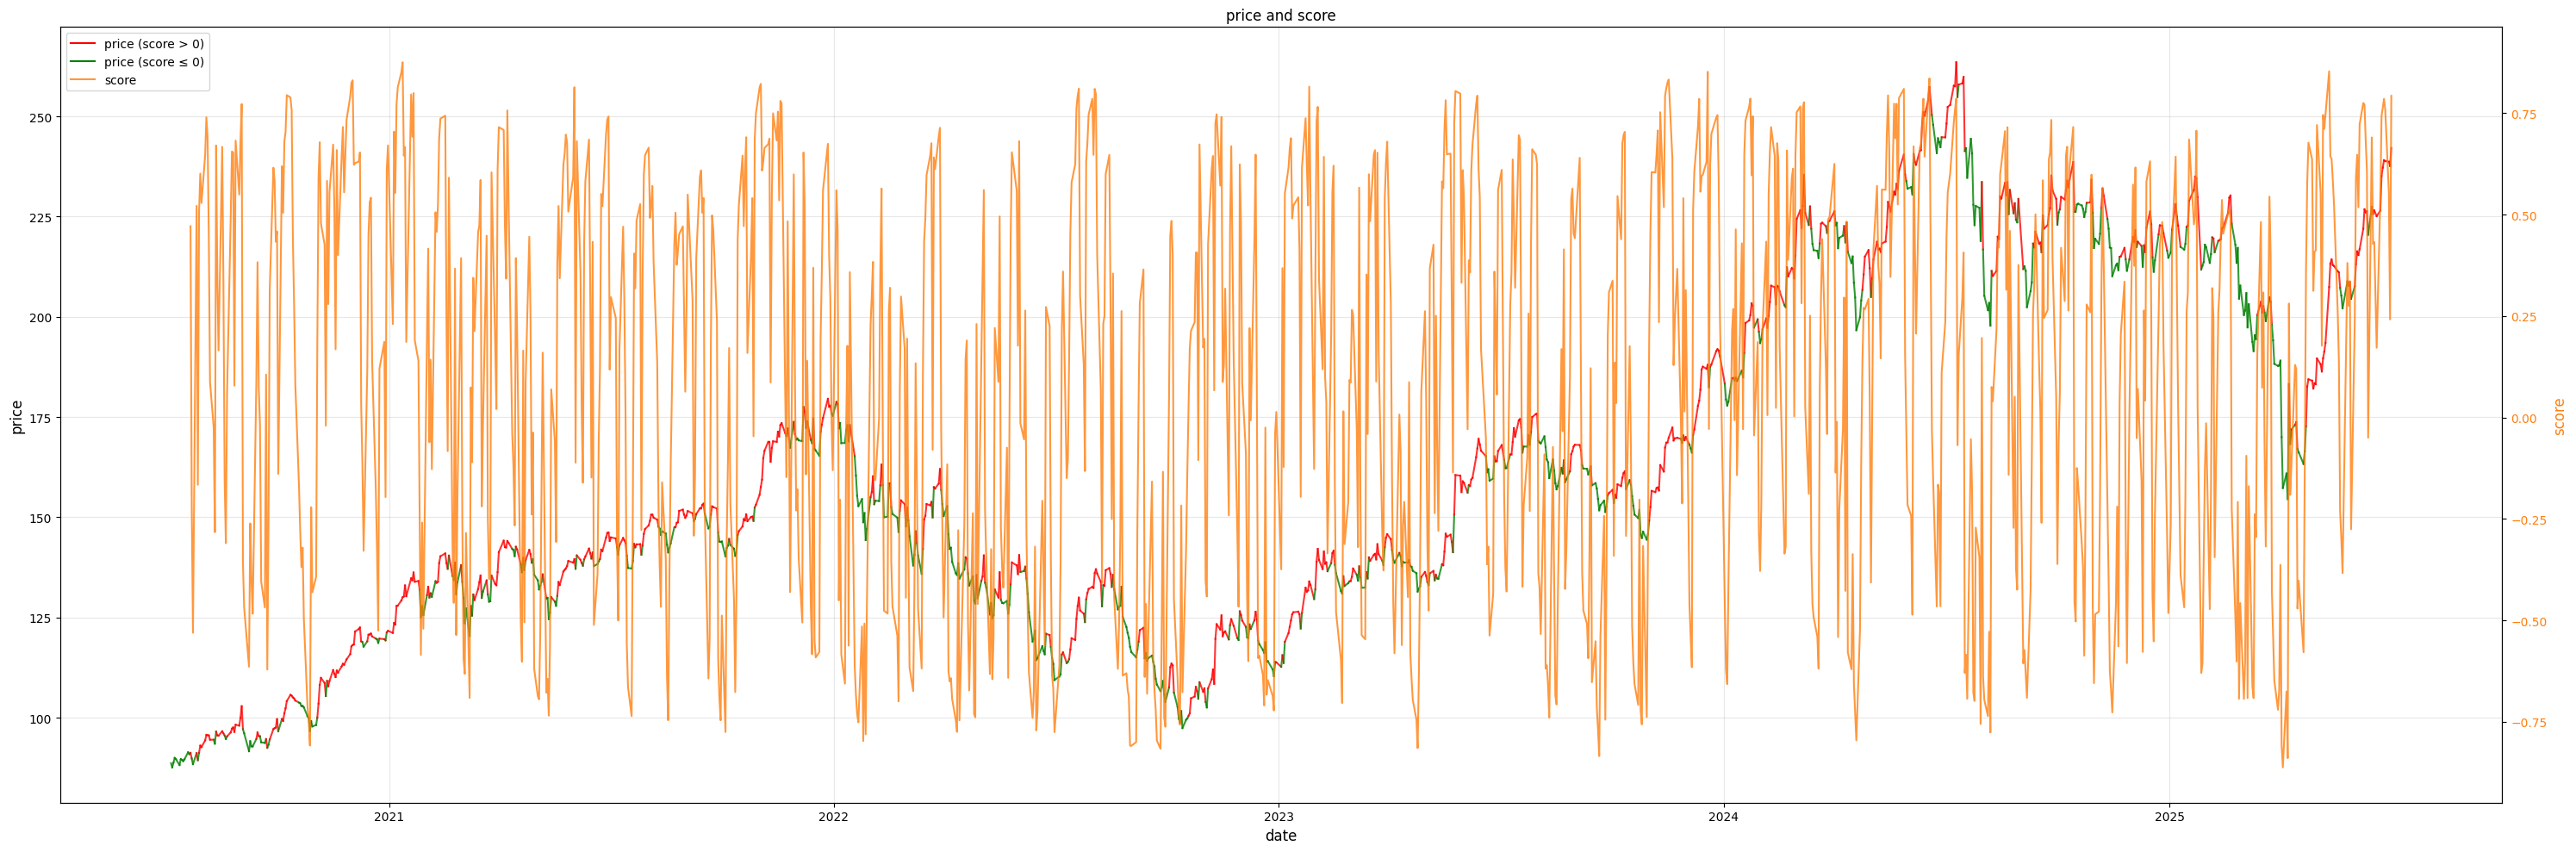

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rescaled_rsi(price:pd.Series,N:int):
    # rescale the classical RSI to a codomain of -1.0 to 1.0
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=N).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=N).mean()
    
    # 避免除零错误
    rs = gain / loss.replace(0, np.inf)  # 将0替换为无穷大
    
    # 计算RSI，处理边界情况
    rsi = 100 - (100 / (1 + rs))
    
    # 处理无穷大和NaN值
    rsi = rsi.replace([np.inf, -np.inf], 100)  # 无穷大时RSI为100
    rsi = rsi.fillna(50)  # NaN值设为中性值50
    
    # 确保值域在0-100之间
    rsi = np.clip(rsi, 0, 100)
    
    # 缩放到-1到1
    return (rsi - 50) / 50

def rescaled_candle_range(price:pd.Series,N:int):
    # Compute the current close in relation to the high EF and low GF of the last N days
    high_ef = price.rolling(window=N).max()
    low_gf = price.rolling(window=N).min()
    candle_range = (price - low_gf) / (high_ef - low_gf)
    return 2*candle_range - 1

def score_emotion(price:pd.Series):
    rrsi = [5,10,14,20]
    rcr = [3,5,8,13]
    score = pd.Series(0,index=price.index)
    for i in range(len(rrsi)):
        score += rescaled_rsi(price,rrsi[i])
    for i in range(len(rcr)):
        score += rescaled_candle_range(price,rcr[i])
    return score / (len(rrsi) + len(rcr))

df_emotion = df.copy()
price = df_emotion['close']
score_emotion = score_emotion(price)
score_plot(price,score_emotion)

### 择时模块
在情绪中性时评估趋势

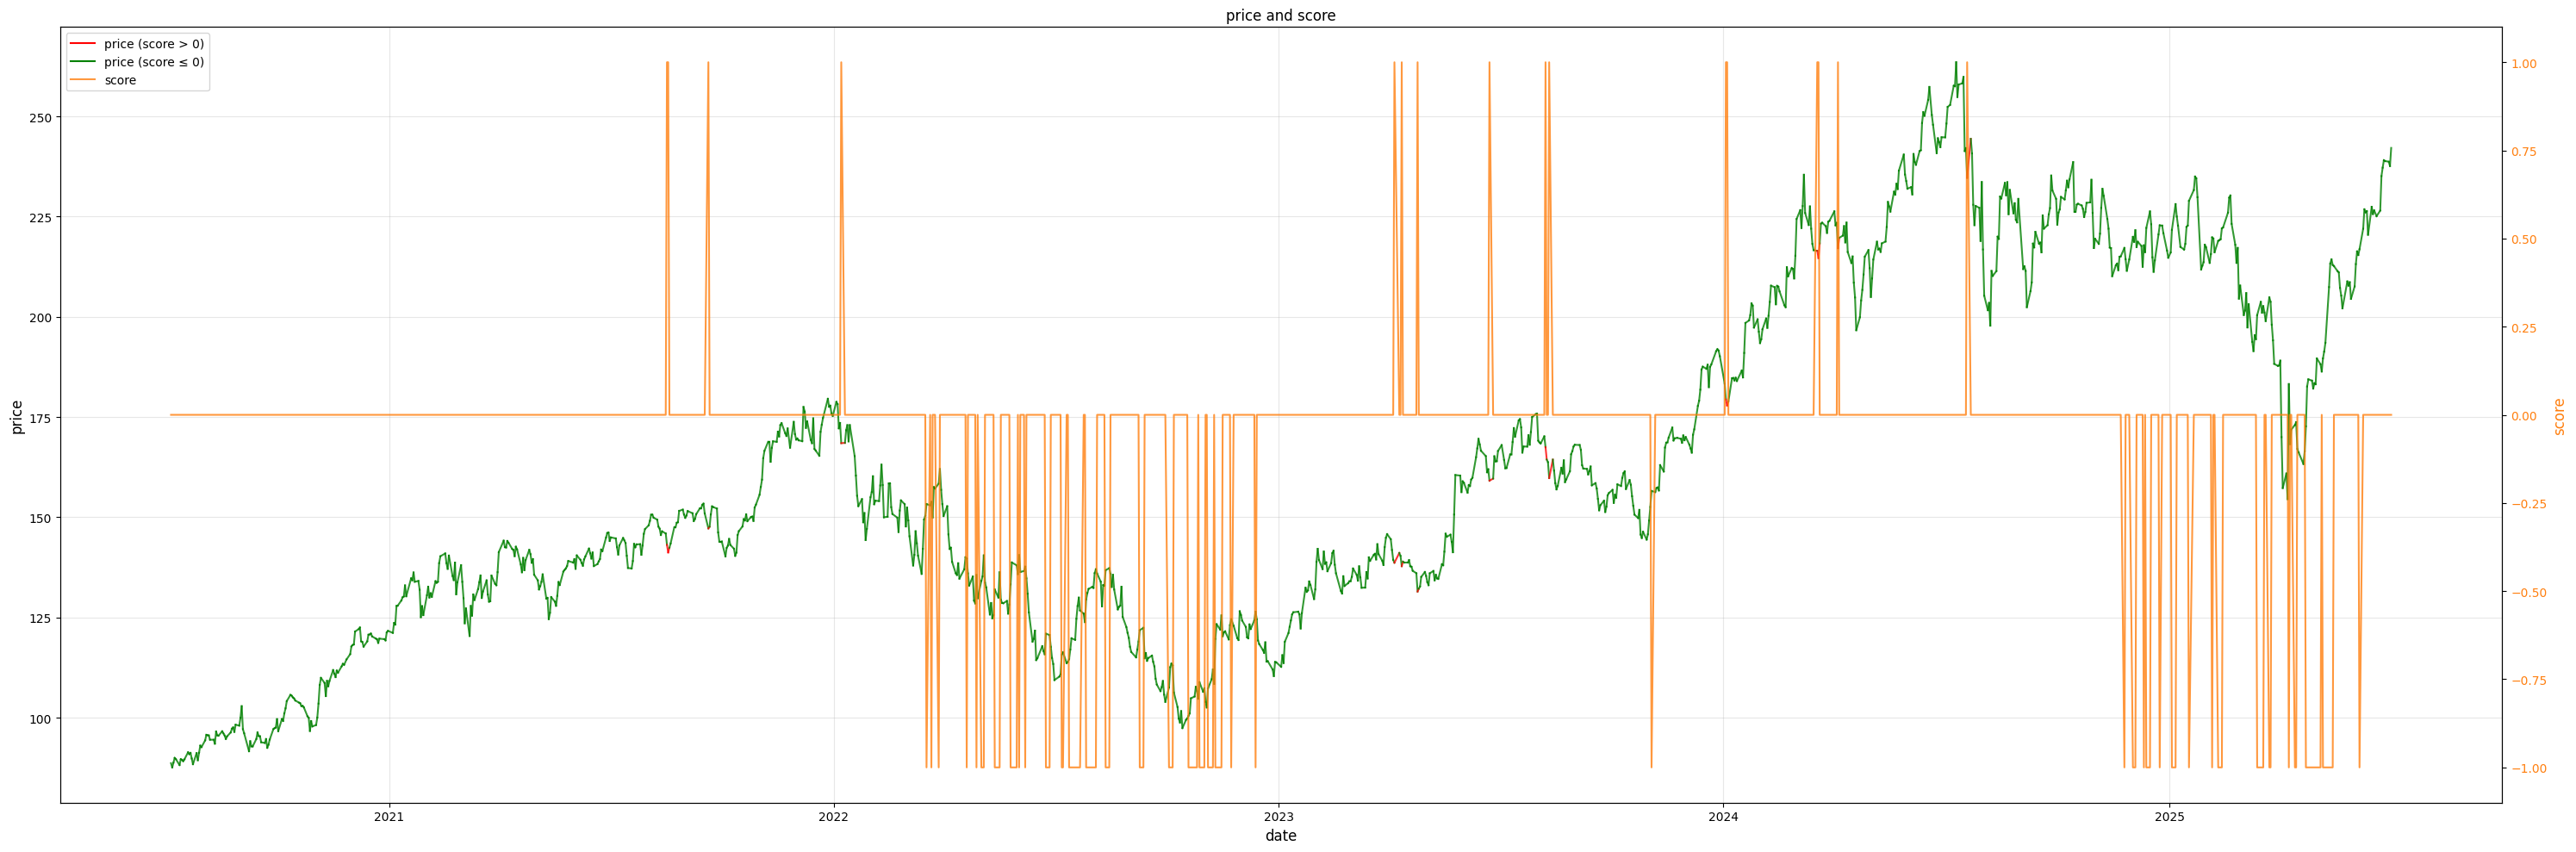

In [96]:
def anchored_trend_score(joint_score:pd.Series,score_emotion:pd.Series):
    update_condition = ((score_emotion > 0) & (score_emotion.shift(1) < 0)) | ((score_emotion < 0) & (score_emotion.shift(1) > 0))
    anchored_trend = joint_score.copy()
    anchored_trend[update_condition] = joint_score[update_condition]
    anchored_trend[~update_condition] = anchored_trend.shift(1)
    return anchored_trend

def timing_indicator(anchored_score:pd.Series,score_emotion:pd.Series):
    # 交易信号：
    # 多头：Timing_Indicator > 1.0（上升趋势+超卖）
    # 空头：Timing_Indicator < -1.0（下降趋势+超买）
    timing_indicator = anchored_score - score_emotion
    return np.select([timing_indicator > 1,timing_indicator < -1], [1, -1], default=0)

def trend_emotion_timing(price:pd.Series,score_emotion:pd.Series):
    score_trend = trend_score(price)
    anchored_score = anchored_trend_score(score_trend,score_emotion)
    timing = timing_indicator(anchored_score,score_emotion)
    return pd.Series(index=price.index,data=timing)

timing = trend_emotion_timing(df_stock['close'],score_emotion)
score_plot(df_stock['close'],timing)






    

